# Implementing a saliency map for nlp

As per the assignment, a saliency map was calulated and generated using pytorch functions. The aim was to learn how to manipulate a pytorch model, extract gradients, and explore the area of model explainability. I used the assignment to do my own further analysis in model explainability. **In the assignment, we evaluated the semtiment model trained to predict the moral utility of a statement. This project extends the assignment by evaluating a different model and adding further analysis.**


1. This notebook first uses `thermostat` with the imdb sentiment model. This is an example of a saliency map (it visualises a tokens importance to the output).

2. Then the notebook illustrates how a saliency map can be made by computing the gradients. **This is the homework assignment**. This visualisation shows to what extent a specific token negatively or positively impacts  

3. Finally, the notebook contains example analysis using the method. Further analysis is done in the next notebook. (Separated for readability).

## 1. Saliency Map with Thermostat

https://github.com/DFKI-NLP/thermostat

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import thermostat 

### 1.1 Load the artifacts for the thermostat example/ demo

In [15]:
data = thermostat.load("imdb-bert-lig")
print(data)

IMDb dataset, BERT model, Layer Integrated Gradients explanations
Dataset: imdb
Model: textattack/bert-base-uncased-imdb
Explainer: LayerIntegratedGradients



This is an an instance of the dataset and visualisation we want to emulate for a new dataset 

The saliency map visualisaes the the attribution score. It iis how the specific token positively or negatively impacts the final prediction

In [16]:
instance = data[250]

print(f'Index: {instance.idx}')
print(f'Attributions (first 5): {instance.attributions[:5]}')
print(f'True label: {instance.true_label}')
print(f'Predicted label: {instance.predicted_label}')

Index: 250
Attributions (first 5): [0.0, 0.2166113704442978, 0.034326110035181046, 0.1554376184940338, 0.06493246555328369]
True label: pos
Predicted label: pos


In [17]:
instance.render() # Visualisation

## 2. Analysing a new dataset: 

The outline of the homework task was
1.  We will be loading the model and corresponding tokenizer.  Note that the model and tokenizers go hand in hand.
2.  We will compute the gradients of the model and write up a description of what it means.
3.  We will recreate the above renderer to be able to display the utility of each word.
4. We will be examining some inconsistencies or failures of current language models.
5. We will ask you to see if you can discover any other inconsistencies yourself. 

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.manual_seed(42)

In [28]:
!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION='python'

In [29]:
tokenizer = AutoTokenizer.from_pretrained("pfr/utilitarian-deberta-01")

TypeError: Couldn't build proto file into descriptor pool: duplicate file name (sentencepiece_model.proto)

In [26]:
tokenizer = AutoTokenizer.from_pretrained("pfr/utilitarian-deberta-01")
model = AutoModelForSequenceClassification.from_pretrained("pfr/utilitarian-deberta-01")

Downloading: 100%|██████████| 961/961 [00:00<00:00, 264kB/s]
Downloading: 100%|██████████| 1.74G/1.74G [05:33<00:00, 5.21MB/s]  


In [ ]:
def tokenize_sentences(tokenizer, sentences, max_length=512):
    """
    Function that takes in the tokenizes the sentences.

    Returns
        input ids: 
            The ids of the tokenized versions of the words.  This is usually
            byte pair encodings (BPE).
        attention mask: 
            Signifies which of the tokens from the input ids are valid for processings.
            The remaining tokens will not affect the output or gradients.
        token type ids: 
            Used to differentiate if tokens represent different things
            such as in the context of Question Answering questions will have type 0 
            and answers will have type 1.
            Depending on the model this might be the value None.
    """
    # ========== v Your Code Here v ========== #
    # Convert the sentences into the input ids and attention mask.

    encoded_inputs = tokenizer(sentences, max_length=max_length, padding='max_length', return_tensors='pt')
    return encoded_inputs['input_ids'], encoded_inputs['attention_mask'], encoded_inputs['token_type_ids']

    # ========== ^ Your Code Here ^ ========== #

In [ ]:
def print_utility(sequences, utilities):
    for sequence, utility in zip(sequences, utilities):
        print(f'"{sequence}" has utility {utility}')

In [ ]:
#Defining arguments for loading the model
# Note that if you try other models 
# you may need to change some of the code to get it to work.
model_name = "microsoft/deberta-v3-large"
model_path = "/content/deberta-v3-large_1e-05_16_2.pkl"
# model_name= "distilbert-base-uncased-finetuned-sst-2-english"

max_length = 64
num_gpus = 0

In [ ]:
#Loading the model
util_model = load_model(model_name, model_path, num_gpus)
_ = util_model.eval()

tokenizer = load_tokenizer(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Measuring Utility

In [ ]:
#Sample sentences and their utility values as predicted by the model (the utility value is simply the model output/logit)
sentences = ["A meteor hit the Earth and Earth exploded.", 
             "A meteor wiped out all life on Earth.", 
             "I found a cure to all diseases.", 
             "I killed 1000 people."]

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=sentences, max_length=max_length)

with torch.no_grad():
    # ========== v Your Code Here v ========== #
    # Get the utilities from the model.
    utilities = util_model(input_ids, attention_mask=input_mask)['logits']
    # ========== ^ Your Code Here ^ ========== #
    

print_utility(sentences, utilities)

"A meteor hit the Earth and Earth exploded." has utility tensor([-12.6104])
"A meteor wiped out all life on Earth." has utility tensor([-12.2945])
"I found a cure to all diseases." has utility tensor([7.3104])
"I killed 1000 people." has utility tensor([-7.8252])


# Computing the Gradient


In [ ]:
# Getting the gradients for the input words gives us 
# the best estimate of the utility for a given word being inputted.
# Getting the gradients with hugging face is rather complex so we have provided
# the functions here as a reference.
def _register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.deberta.embeddings.word_embeddings
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def _register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0])
    embedding_layer = model.deberta.embeddings.word_embeddings
    hook = embedding_layer.register_backward_hook(hook_layers)
    return hook

# You will be using this function below to get the gradients.
def get_saliency_map(model, input_ids, token_type_ids, input_mask):
    torch.enable_grad()
    model.eval()
    embeddings_list = []
    handle = _register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = _register_embedding_gradient_hooks(model, embeddings_gradients)

    model.zero_grad()
    # ========== v Your Code Here v ========== #
    
    output = model(input_ids, attention_mask=input_mask)
    output['logits'][0].backward() 

    # ========== ^ Your Code Here ^ ========== #

    handle.remove()
    hook.remove()

    saliency_grad = embeddings_gradients[0].detach().cpu().numpy()        
    saliency_grad = np.sum(saliency_grad * embeddings_list[0], axis=-1)
    norm = np.linalg.norm(saliency_grad, ord=1)
    saliency_grad = [e / norm for e in saliency_grad] 
    
    return saliency_grad

#### TODO by you
*  Please write equation for computing the gradient of the loss (L2 loss) with respect to the weights of the last layer.  This is a general equation not specific to any architecture or model.

DLoss/Dw = 
* Expanding on the above how does the equation change if I tell you that the weights are a convolution kernel? the weights are a linear operator? 


*  Please describe what the gradients of the loss with respect to the inputs represents.

This represents the rate at which changing each feature would change the prediction away from the ground truth. 

*  What does the does the gradient of the loss with respect to the input represent when you take the negative of the loss?

This represents the rate at which changing each feature would change the prediction towards the ground truth. 

Answers go here

In [ ]:
saliency_maps = []
# ========== v Your Code Here v ========== #
# TODO: Get a saliency map for every sentence by calling the 
# provided saliency_map function.
saliency_maps = get_saliency_map(util_model, input_ids, _, input_mask)
# ========== ^ Your Code Here ^ ========== #

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


After loading and playing with the model we will now create another render function to display the utility scores as we did above.

In [ ]:
def visualize(tokens, saliency_map):
    # ========== v Your Code Here v ========== #
    # TODO: 
    # Write a function to visualize the tokens and the saliency map
    # overlayed on top the tokens.  Feel free to use the previous visualize 
    # function as a reference for the function you'll write below.
    y = saliency_map[:len(tokens)]
    x = [i for i in range(len(tokens))]
    plt.bar(x, y)
    plt.xticks(x, tokens)

    # ========== ^ Your Code Here ^ ========== #

Now we want to visualize the saliency maps for the tokens.

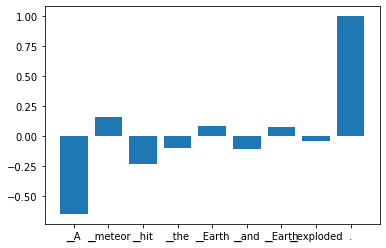

In [ ]:
visualize(tokenizer.tokenize(sentences[0]), saliency_maps[0])

# Inconsitencies or Model Failures

### Inconsistency with Scope Intensity
You should expect some monotonic behaviour with some things.  The model however expresses odd behavior that isn't monotonic in its outputs.

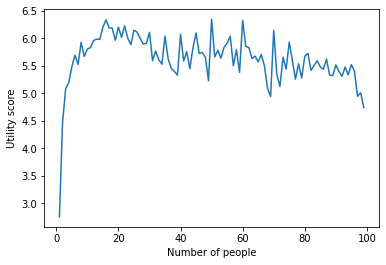

In [ ]:
sentence = 'I saved x people'

input_sents = [sentence.replace('x', str(i)) for i in np.arange(1, 100, 1)]
input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

plt.plot(np.arange(1, 100), output_utils)
plt.xlabel('Number of people')
plt.ylabel('Utility score')
plt.show()

### Framing the problem
Even if two sentences express the same idea or concept they can have very different utilities which is not a useful property if we want the model to reflect the true utility.

In [ ]:
sentences = ['I performed surgery on a patient with a 50% chance of success.',
             'I performed surgery on a patient with a 50% chance of failure.']

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)
with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

print_utility(sentences, output_utils)

"I performed surgery on a patient with a 50% chance of success." has utility tensor([2.7512])
"I performed surgery on a patient with a 50% chance of failure." has utility tensor([4.4566])


### Inconsistencies in utility functions: Distracted by noise

In [ ]:
sentences = ['I won $100,000.', 'I won $101,101.']

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)
with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

print_utility(sentences, output_utils)

"I won $100,000." has utility tensor([2.7512])
"I won $101,101." has utility tensor([4.4566])


## Bias
The utility function might also present bias that is similar to what humans might have.

**Gender/Age**

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


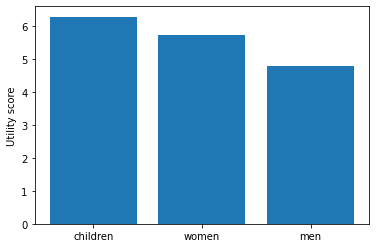

In [ ]:
sentence = 'I saved 1,000,000 [MASK]\'s lives today'

input_sents = [sentence.replace('[MASK]', s) for s in ['children', 'women', 'men']]
input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

plt.bar(range(3), output_utils, tick_label=['children', 'women', 'men'])
plt.ylabel('Utility score')
plt.show()

**Race/Gender**

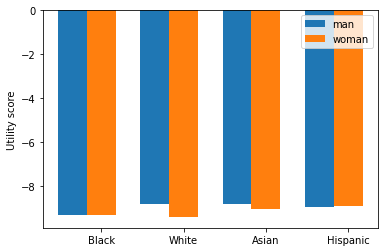

In [ ]:
def gender_bias(isMan: bool):
    gender = 'man' if isMan else 'woman'
    indent = 0 if isMan else 1

    race = ['Black', 'White', 'Asian', 'Hispanic']

    sentence = f'[MASK] {gender} dies.'

    input_sents = [sentence.replace('[MASK]', s) for s in race]
    input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

    with torch.no_grad():
        output_utils = util_model(input_ids, attention_mask=input_mask)[0]

    bar_width = 0.35

    plt.bar(np.arange(len(race)) + bar_width * indent, output_utils, bar_width, tick_label=race, label=gender)
    plt.ylabel('Utility score')

gender_bias(True)
gender_bias(False)
plt.legend()
plt.show()

### TODO by you
For the final part assignment we encourage you to explore the model and find at least two other inconsistencies and do a short write up of the inconsistency.   

*  Why is it an inconsistency or model failure?
*  What should the model output instead?
*  What is the pattern of failures?
*  Is the failure itself consistent or inconsistent?


Here, this plot highlights two inconsistencies - one regarding the size as an adjective and animal species. 

This is an inconsistency as between species of animals with similar consiousness, they should have similar utility values. Eg. cats and dogs should have similar scores. The pattern of failure reflects the value we put to these animals. The failure seems somewhat consistant.

The inconsistency of the shape is that describing the animal dying's shape changes the utility score. It is fairly consistent.


/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


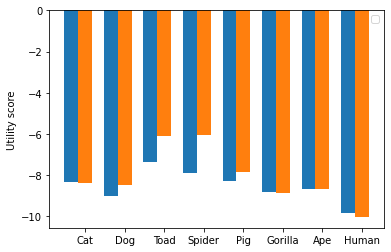

In [ ]:
# ========== v Your Code Here v ========== #
# TODO write code to test out other biases

def animal_bias(adjective: str, indent):

    species = ['Cat', 'Dog', 'Toad', 'Spider', 'Pig', 'Gorilla', 'Ape', 'Human']

    sentence = f'{adjective} [MASK] dies.'

    input_sents = [sentence.replace('[MASK]', s) for s in species]
    input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

    with torch.no_grad():
        output_utils = util_model(input_ids, attention_mask=input_mask)[0]

    bar_width = 0.35

    plt.bar(np.arange(len(species)) + bar_width * indent , output_utils, bar_width, tick_label=species)
    plt.ylabel('Utility score')

animal_bias("Big", 0)
animal_bias("Small", 1)
plt.legend()
plt.show()

# ========== ^ Your Code Here ^ ========== #